In [173]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from numba import njit, cuda
from numpy.typing import NDArray

In [156]:
@cuda.jit
def fitness(individs: NDArray[np.float64], points: NDArray[np.float64], fitnesses: NDArray[np.float64]):
    i = cuda.grid(1)
    if i < individs.shape[0]:
        individ = individs[i, :]
        err = 0
        for k in range(points.shape[0]):
            point = points[k, :]
            f_approx = 0                 
            for j in range(individ.shape[0]):
                f_approx += individ[j] * point[0] ** j
            if abs(f_approx - point[1]) > err:
                err = abs(f_approx - point[1])
        fitnesses[i] = err


In [158]:
@cuda.jit
def crossover(individs: NDArray[np.float64], population_size: int, children: NDArray[np.float64], 
              crosspoints: list[int], parent1: list[int], parent2: list[int]):
    i = cuda.grid(1)
    if i < population_size:
        p1 = individs[parent1[i], :]
        p2 = individs[parent2[i], :]

        crosspoint = crosspoints[i]

        c1 = p1[:crosspoint]
        c2 = p2[crosspoint:]
       
        for j in range(crosspoint):
            children[i, j] = c1[j]
            children[i, crosspoint + j] = c2[j]

In [170]:
def mutation(individs: NDArray[np.float64]) -> NDArray[np.float64]:
    mutation_count = random.randint(1, individs.shape[1])
    for i in range(mutation_count):
        index = random.randint(0, individs.shape[0] - 1)
        gens_count = random.randint(1, individs.shape[1])
        gen_max = max(individs[index])
        for j in range(gens_count):
            individs[index, random.randint(0, individs.shape[1] - 1)] += np.random.uniform(-gen_max, gen_max)
    return individs

In [161]:
def selection(individs: NDArray[np.float64] , fitnesses: NDArray[np.float64]) -> tuple[NDArray[np.float64], float]:
    sorted_fitnesses = sorted(zip(individs, fitnesses), key=lambda x: x[1])
    ind, fit = map(list, zip(*sorted_fitnesses))
    return np.array(ind), np.array(fit)

In [168]:
def genetic_algorithm(points: NDArray[np.float64], degree: int, population_size: int, 
                      err: float, max_iter: int, initial = float("inf")) -> tuple[NDArray[np.float64], float]:

    population_shape = population_size, degree
    
    population = np.random.random(population_shape)
    best_fitness = initial 
    
    points_dev = cuda.to_device(points)
    
    for i in range(max_iter):
        children = np.zeros(population_shape)
        
        population_dev = cuda.to_device(population[:population_size // 2, :])
        children_dev = cuda.to_device(children)
        
        crosspoints = [random.randint(1, children.shape[1]) for _ in range(population_size)]
        parent1 = [random.randint(0, population_dev.shape[0] - 1) for _ in range(population_size)]
        parent2 = [random.randint(0, population_dev.shape[0] - 1) for _ in range(population_size)]
   
        crosspoints_dev = cuda.to_device(crosspoints)
        parent1_dev = cuda.to_device(parent1)
        parent2_dev = cuda.to_device(parent2)
        
        crossover[int(population_size // 512) + 1, 512](population_dev, population_size, children_dev,
                                                        crosspoints_dev, parent1_dev, parent2_dev)
        
        population = children_dev.copy_to_host()
        
        population = mutation(population)
        
        fitnesses = np.zeros(population.shape[0])
        
        fitnesses_dev = cuda.to_device(fitnesses)
        
        fitness[int(population_size // 512) + 1, 512](children_dev, points_dev, fitnesses_dev)
        
        current_fitnesses = fitnesses_dev.copy_to_host()
        
        population, current_fitnesses = selection(population, current_fitnesses)
        
        if i != 0 and current_fitnesses[0] < best_fitness:
            best_fitness = current_fitnesses[0]
            best_ind = population[0, :]           
            
        if best_fitness < err:
            break
            print(f"{i} iteration, fitness: {best_fitness}")
    return best_ind, best_fitness

### Генерация данных и построение распределения 

In [163]:
def generate_data(function, point_count, x_min, x_max, std):
    x = np.linspace(x_min, x_max, point_count)
    y = function(x)
    y += np.random.random(point_count) * std - std / 2
    return x, y

In [164]:
coeffs = np.random.random(5)
coeffs

array([0.9440897 , 0.68400167, 0.66198956, 0.5027309 , 0.32185726])

In [165]:
polymon = lambda x: coeffs[4] * x ** 4 + coeffs[3] * x ** 3 + coeffs[2] * x ** 2 + coeffs[1] * x + coeffs[0] 
x, y = generate_data(polymon, 1000, -3, 3, 3.0)

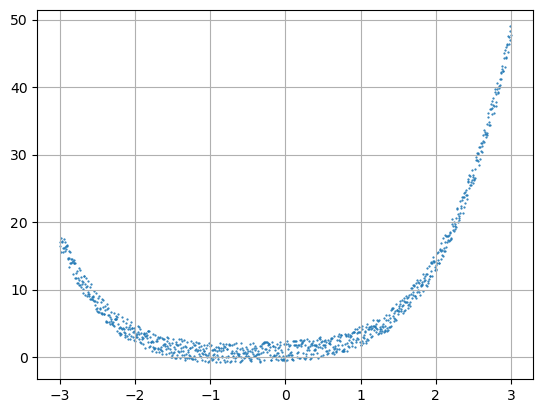

In [166]:
plt.scatter(x, y, s=0.3)
plt.grid()

### Применение генетического алгоритма для аппроксимации 

In [175]:
points = np.hstack([x.reshape(x.shape[0], 1), y.reshape(y.shape[0], 1)], dtype=np.float64) # набор пар x, y

start = time.time()

params, err = genetic_algorithm(points, 5, 1000, 0.001, 2000, float("inf"))

elapsed_time = time.time() - start

print(f"Elapsed time: {elapsed_time} s\n"
      f"{params[0]} + {params[1]}*x + {params[2]}*x**2 + {params[3]}*x**3 + {params[4]}*x**4")

Elapsed time: 20.90976047515869 s
0.9579898764852531 + 0.42696157238607124*x + 0.5522199610683483*x**2 + 0.5310967215747281*x**3 + 0.3387736234086779*x**4


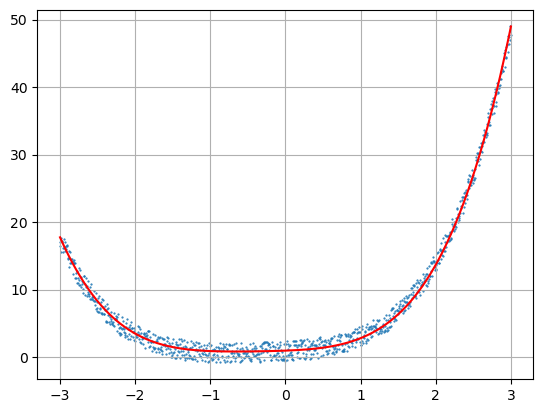

In [176]:
plt.scatter(x, y, s=0.3)
plt.plot(x, params[0] + params[1]*x + params[2]*x**2 + params[3]*x**3 + params[4]*x**4, c='r')
plt.grid()